In [198]:
import torch
import pickle
import numpy as np


In [199]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GATConv
import torch.nn as nn
import math


# Data Collection

### **Purpose of Merging**
Combining the `bene` and `claims` datasets serves to:
1. Enrich claim data with beneficiary details such as demographics and health conditions.
2. Enable the creation of features like claim durations and beneficiary age.
3. Link fraud labels to claims for fraud detection tasks.
4. Simplify graph-based modeling by establishing relationships between claims and beneficiaries.

### **Date Range Check**
Verifying the `ClaimStartDt` range ensures the dataset covers the desired time period for analysis.

### **Summary**
This step creates a unified dataset for feature engineering, fraud detection, and graph-based learning.


In [262]:
import pandas as pd
import os
from sklearn import preprocessing
import numpy as np
data_route="./Dataset/"

bene=pd.read_csv(data_route+'bene.csv')
claims=pd.read_csv(data_route+'claims.csv')
data_join=pd.merge(claims,bene,on='BeneID',how='left')
#data_join['ClaimStartDt']=pd.to_datetime(data_join['ClaimStartDt'])
print(data_join['ClaimStartDt'].max())
print(data_join['ClaimStartDt'].min())

2009/12/31
2008/11/27


# Data Preprocessing

### **Step-by-Step Preprocessing Workflow**

1. **Feature Extraction from Dates**:
   - A function, `date_to_feature`, extracts the year, month, and day from date columns (e.g., `DOB`). These features are added as new columns, making the date information numeric and easier to use in models.

2. **Feature Engineering**:
   - **`DateDiff`**: The difference in days between `ClaimStartDt` and `ClaimEndDt` is calculated and stored as a new column. The `ClaimEndDt` column is then dropped to avoid redundancy.
   - **`AdmissionDiff`**: The difference in days between `AdmissionDt` and `DischargeDt` is calculated and stored. The original date columns (`AdmissionDt` and `DischargeDt`) are dropped afterward.

3. **Binary Conversion for `DOD`**:
   - The `DOD` column is transformed into a binary feature: 
     - `1` indicates a valid date.
     - `0` indicates the value was `-1`.

4. **Value Normalization**:
   - Columns related to chronic conditions and diagnostics (e.g., `ChronicCond_Heartfailure`, `DiagnosisGroupCode`) are adjusted:
     - Their values are decreased by either `1` or `10,000`, depending on the column, to normalize them.

5. **Handling `DOB`**:
   - The `DOB` column is processed using the `date_to_feature` function to extract year, month, and day.
   - The original `DOB` and redundant features like `DOB_day` are dropped.

6. **Daily Grouping of Claims**:
   - The data is divided into daily groups based on `ClaimStartDt`. Claims that fall within the same day are grouped together to enable temporal analysis and incremental processing.

7. **Edge Creation for Graph Representation**:
   - Edges are created between claims based on:
     - Shared `BeneID` (claims belong to the same beneficiary).
     - Shared `Provider` (claims involve the same service provider).
   - Optionally, temporal constraints (e.g., claims within 5 days) can be applied.

8. **Edge Transformation**:
   - The edges are reformatted into a two-dimensional structure for graph neural network (GNN) compatibility.
   - Undirected edges are created by duplicating each edge in reverse.

9. **Feature Scaling**:
   - Numerical features are normalized using MinMaxScaler to ensure all features lie within a similar range for GNN training.

10. **Dataset Preparation**:
    - **Online Dataset**: Groups daily claim data into a format suitable for online (incremental) training.
    - **Contrast Dataset**: Separates data into fraud and non-fraud groups for contrastive learning.

11. **Serialization**:
    - The processed datasets are saved as files (`datasetonline.dat` and `datasettwo.dat`) for future use in model training and evaluation.

---

### **Summary**
This code processes the merged dataset to create numerical features, graph structures, and datasets tailored for graph neural network (GNN) and machine learning tasks. It includes steps for temporal grouping, edge creation, feature scaling, and saving the results for efficient usage.


In [263]:
# Define a function to convert a date column to year, month, and day features
def date_to_feature(data, column):
    column_year = column + '_year'
    column_month = column + '_month'
    column_day = column + '_day'
    data[column_year] = data[column].dt.year
    data[column_month] = data[column].dt.month
    data[column_day] = data[column].dt.day
    return data


In [264]:
# Convert ClaimStartDt and ClaimEndDt difference to DateDiff
data_join['DateDiff'] = pd.to_datetime(data_join['ClaimEndDt']) - pd.to_datetime(data_join['ClaimStartDt'])
data_join['DateDiff'] = data_join['DateDiff'].dt.days
data_join.drop(['ClaimEndDt'], axis=1, inplace=True)

# Calculate the difference between AdmissionDt and DischargeDt
data_join['AdmissionDiff'] = pd.to_datetime(data_join['DischargeDt']) - pd.to_datetime(data_join['AdmissionDt'])
data_join['AdmissionDiff'] = data_join['AdmissionDiff'].dt.days

# Modify DOD values
data_join['DOD'] = data_join['DOD'].apply(lambda x: 0 if x == '-1' else 1)

data_join.head()


,ClaimID,BeneID,ClaimStartDt,Provider,InscClaimAmtReimbursed,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,DateDiff,AdmissionDiff
0,100000,102311,2008/12/12,1853,30,1969/12/31,10000,0.0,1969/12/31,10000,...,1,2,2,2,4150,1068,1690,1090,20,0
1,100001,103298,2008/12/12,3147,1600,1969/12/31,10000,0.0,1969/12/31,10000,...,1,1,2,2,0,0,22220,5390,20,0
2,100002,104153,2008/12/12,1633,200,1969/12/31,10000,0.0,1969/12/31,10000,...,2,2,2,2,0,0,1250,340,20,0
3,100003,104463,2008/12/12,5002,1900,1969/12/31,10000,0.0,1969/12/31,10000,...,1,1,2,2,16000,1068,25700,6990,20,0
4,100004,107584,2008/12/12,4591,400,1969/12/31,12708,0.0,1969/12/31,10000,...,2,1,2,2,0,0,490,140,20,0


In [265]:
# Subtract 1 from specified columns
need_minusone = ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 
                 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
                 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 
                 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'Gender', 'Race']
for i in need_minusone:
    data_join[i] = data_join[i].apply(lambda x: x - 1)

# Subtract 10000 from other specified columns
need_10000minusone = ['ClmAdmitDiagnosisCode', 'DiagnosisGroupCode']
for i in need_10000minusone:
    data_join[i] = data_join[i].apply(lambda x: x - 10000)


In [266]:
# Drop the columns AdmissionDt and DischargeDt
data_join.drop(['AdmissionDt', 'DischargeDt'], axis=1, inplace=True)


In [267]:
# Convert DOB to features using date_to_feature and remove DOB
data_join['DOB'] = pd.to_datetime(data_join['DOB'])
data_join = date_to_feature(data_join, 'DOB')
data_join.drop(['DOB'], axis=1, inplace=True)
data_join.drop(['DOB_day', 'PotentialGroupFraud'], axis=1, inplace=True)

# Convert ClaimStartDt to datetime
data_join['ClaimStartDt'] = pd.to_datetime(data_join['ClaimStartDt'])


In [268]:
# Split data into daily groups based on ClaimStartDt
de_day = 1
next_data = []
start_date = pd.to_datetime('2009-01-01')
while start_date < pd.to_datetime('2009-12-31'):
    temp = data_join[(data_join['ClaimStartDt'] >= start_date) & (data_join['ClaimStartDt'] < start_date + pd.Timedelta(days=de_day))]
    next_data.append(temp)
    start_date = start_date + pd.Timedelta(days=de_day)


In [269]:
data_join.head()

,ClaimID,BeneID,ClaimStartDt,Provider,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DiagnosisGroupCode,inpatent,PotentialFraud,...,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,DateDiff,AdmissionDiff,DOB_year,DOB_month
0,100000,102311,2008-12-12,1853,30,0,0.0,0,0,1,...,1,1,4150,1068,1690,1090,20,0,1932,2
1,100001,103298,2008-12-12,3147,1600,0,0.0,0,0,0,...,1,1,0,0,22220,5390,20,0,1943,11
2,100002,104153,2008-12-12,1633,200,0,0.0,0,0,0,...,1,1,0,0,1250,340,20,0,1943,4
3,100003,104463,2008-12-12,5002,1900,0,0.0,0,0,1,...,1,1,16000,1068,25700,6990,20,0,1919,3
4,100004,107584,2008-12-12,4591,400,2708,0.0,0,0,0,...,1,1,0,0,490,140,20,0,1931,11


In [270]:
# Define function to create edges based on BeneID or Provider
def create_edges(data, large=0):
    data = data.reset_index(drop=True)
    edges = []
    # Group by BeneID
    datagroup = data.groupby(['BeneID'])
    for i in datagroup:
        if len(i[1]) > 1:
            index = i[1].index
            for j in range(len(index)):
                indexa = index[j]
                for k in range(j + 1, len(index)):
                    indexb = index[k]
                    if (large == 0) or (i[1].iloc[j]['ClaimStartDt'] - i[1].iloc[k]['ClaimStartDt']) < pd.Timedelta(days=5):
                        if indexa < indexb:
                            edges.append((indexa, indexb))
                        else:
                            edges.append((indexb, indexa))

    # Group by Provider
    providergroup = data.groupby(['Provider'])
    for i in providergroup:
        if len(i[1]) > 1:
            index = i[1].index
            for j in range(len(index)):
                indexa = index[j]
                for k in range(j + 1, len(index)):
                    indexb = index[k]
                    if (large == 0) or (i[1].iloc[j]['ClaimStartDt'] - i[1].iloc[k]['ClaimStartDt']) < pd.Timedelta(days=5):
                        if indexa < indexb:
                            edges.append((indexa, indexb))
                        else:
                            edges.append((indexb, indexa))
    return list(set(edges))

# Transform edges to the required format
def edge_transform(edges):
    edges = np.array(edges)
    edges = edges.T.reshape(2, -1)
    return edges

# Convert pandas DataFrame to numpy and normalize the features
def pandas_to_numpy(data):
    data = data.reset_index(drop=True)
    data = data.drop(['BeneID', 'Provider', 'ClaimStartDt', 'ClaimID'], axis=1)
    data = data.values
    data = preprocessing.MinMaxScaler().fit_transform(data)
    return data

# Convert directed edges to undirected
def turn_to_no_direction(edge):
    edge_begin = edge[0]
    edge_end = edge[1]
    begin_new_begin = np.concatenate((edge_begin, edge_end))
    begin_new_end = np.concatenate((edge_end, edge_begin))
    return np.array([begin_new_begin, begin_new_end])


In [271]:
# Process the data and create dataset
import copy
tempnext_data = copy.deepcopy(next_data)
dataset = []
for i in range(len(next_data)):
    next_data_edge = create_edges(next_data[i], 0)
    next_data_edge = edge_transform(next_data_edge)
    next_data[i] = pandas_to_numpy(next_data[i])
    dataset.append((next_data[i], next_data_edge))

print('next_data_edge finish')
print(len(dataset))

# Convert edges to undirected
for i in range(len(dataset)):  # Convert all edges to undirected graph
    dataset[i] = (dataset[i][0], turn_to_no_direction(dataset[i][1]))

print(len(dataset[0][1][0]))


next_data_edge finish
364
3616


In [272]:
# Save the dataset to file
import pickle
with open(data_route + "datasetonline.dat", "wb") as file:
    pickle.dump(dataset, file)


In [273]:
# Process data again for 'PotentialFraud' column
dataset = []
next_data = tempnext_data
for i in next_data:
    data_all = [i[i['PotentialFraud'] == False], i[i['PotentialFraud'] == True]]
    for j in data_all:
        next_data_edge = create_edges(j, 0)
        next_data_edge = edge_transform(next_data_edge)
        j = pandas_to_numpy(j)
        dataset.append((j, next_data_edge))

print('next_data_edge finish')
print(len(dataset))

# Convert edges to undirected again
for i in range(len(dataset)):  # Convert all edges to undirected graph
    dataset[i] = (dataset[i][0], turn_to_no_direction(dataset[i][1]))

print(len(dataset[0][1][0]))

# Save the second dataset to file
with open(data_route + "datasettwo.dat", "wb") as file:
    pickle.dump(dataset, file)


next_data_edge finish
728
830


# EDA

### Dataset Overview

Analyzed the first five datasets to determine the number of nodes (claims) and edges (relationships). 

- Nodes represent individual claims.
- Edges represent connections based on shared attributes (e.g., BeneID, Provider).

#### Fraud Case Distribution
Computed fraud cases per dataset to identify patterns in fraudulent claims.


In [274]:
for i, (nodes, edges) in enumerate(dataset[:5]):  # Analyze the first 5 datasets
    print(f"Dataset {i+1}:")
    print(f"Number of Nodes: {nodes.shape[0]}")
    print(f"Number of Edges: {edges.shape[1]}")
    print("-" * 30)

fraud_counts = [len(d[0]) for d in dataset if d[0].shape[0] > 0]
print("Fraud Cases Per Dataset:", fraud_counts)


Dataset 1:
Number of Nodes: 997
Number of Edges: 830
------------------------------
Dataset 2:
Number of Nodes: 599
Number of Edges: 2778
------------------------------
Dataset 3:
Number of Nodes: 968
Number of Edges: 804
------------------------------
Dataset 4:
Number of Nodes: 605
Number of Edges: 2774
------------------------------
Dataset 5:
Number of Nodes: 1040
Number of Edges: 1004
------------------------------
Fraud Cases Per Dataset: [997, 599, 968, 605, 1040, 599, 972, 637, 1004, 602, 978, 656, 976, 607, 956, 549, 983, 589, 924, 643, 995, 591, 989, 630, 977, 646, 935, 619, 1003, 600, 923, 611, 975, 641, 976, 626, 988, 651, 980, 623, 1013, 630, 952, 623, 1000, 570, 1007, 592, 1002, 631, 986, 621, 982, 620, 983, 611, 988, 600, 1009, 590, 1071, 638, 973, 627, 1015, 616, 970, 635, 969, 599, 979, 614, 960, 567, 1037, 598, 1009, 627, 966, 640, 1013, 621, 1047, 588, 985, 626, 980, 624, 956, 574, 1033, 628, 1032, 635, 1008, 606, 963, 619, 992, 616, 964, 603, 925, 592, 978, 599, 102

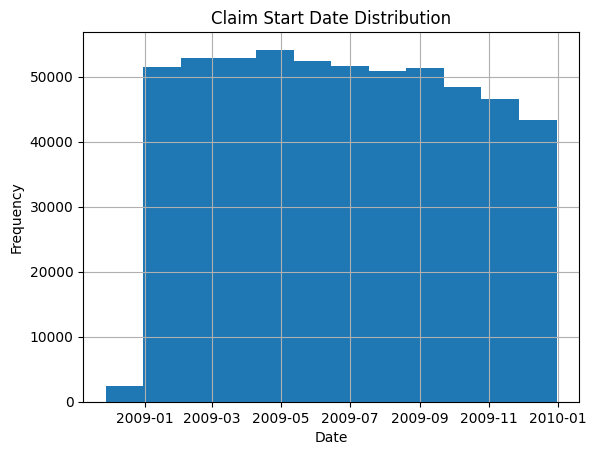

In [275]:
import matplotlib.pyplot as plt
import pandas as pd

claim_dates = data_join['ClaimStartDt']  # Assuming ClaimStartDt is already in datetime format
claim_dates.hist(bins=12)  # Plot histogram
plt.title("Claim Start Date Distribution")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.show()


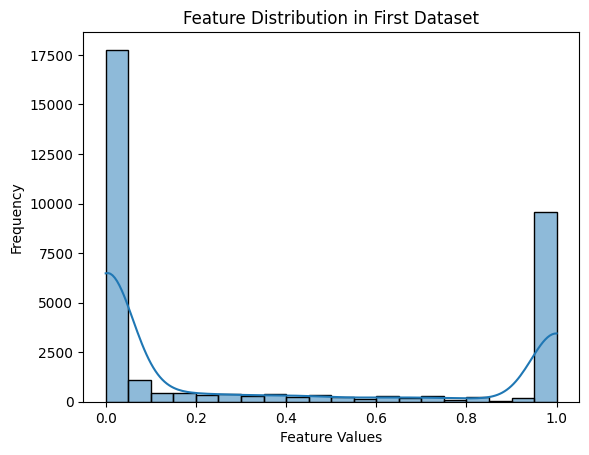

In [276]:
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten and visualize feature distributions from the first dataset
features = dataset[0][0].flatten()
sns.histplot(features, bins=20, kde=True)
plt.title("Feature Distribution in First Dataset")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")
plt.show()


### Feature Correlation Analysis

Identified numerical features correlated with the target variable (`PotentialFraud`). Features with a correlation above a threshold (e.g., 0.1) were selected for further analysis, helping to isolate impactful predictors for fraud detection.


In [277]:
# Ensure numerical columns are used
numerical_features = data_join.select_dtypes(include=[np.number])

# Compute correlation with the target variable
correlation_with_target = numerical_features.corr()["PotentialFraud"].sort_values(ascending=False)
print("Correlation with Target:")
print(correlation_with_target)

# Select features with correlation > threshold (e.g., 0.1)
important_features_corr = correlation_with_target[abs(correlation_with_target) > 0.1].index.tolist()
print("Selected Important Features (Correlation):", important_features_corr)


Correlation with Target:
PotentialFraud                     1.000000
inpatent                           0.113401
DeductibleAmtPaid                  0.112013
DiagnosisGroupCode                 0.096653
AdmissionDiff                      0.082004
InscClaimAmtReimbursed             0.080613
ClmAdmitDiagnosisCode              0.043638
IPAnnualDeductibleAmt              0.036514
IPAnnualReimbursementAmt           0.035027
DateDiff                           0.028640
Race                               0.024486
ClaimID                            0.018949
County                             0.011551
RenalDiseaseIndicator              0.007559
NoOfMonths_PartACov                0.005022
OPAnnualDeductibleAmt              0.002919
OPAnnualReimbursementAmt           0.002077
NoOfMonths_PartBCov                0.001959
DOB_month                          0.000888
Gender                            -0.000460
ChronicCond_Depression            -0.000467
ChronicCond_Osteoporasis          -0.001181
DOD    

### Feature Selection using Random Forest

Applied a Random Forest classifier to rank feature importance for predicting `PotentialFraud`. The top 10 most significant features were selected, providing a data-driven approach to prioritize impactful variables for further analysis.


In [278]:
from sklearn.ensemble import RandomForestClassifier

# Prepare the data
X = data_join.drop(["PotentialFraud", "BeneID", "Provider", "ClaimStartDt", "ClaimID"], axis=1)
y = data_join["PotentialFraud"]

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importance:")
print(feature_importance)

# Select top N features
important_features_rf = feature_importance.nlargest(10).index.tolist()
print("Selected Important Features (Random Forest):", important_features_rf)


Feature Importance:
InscClaimAmtReimbursed             0.208216
County                             0.111128
State                              0.101309
OPAnnualReimbursementAmt           0.079355
OPAnnualDeductibleAmt              0.074823
DOB_year                           0.067586
ClmAdmitDiagnosisCode              0.055759
DOB_month                          0.048931
IPAnnualReimbursementAmt           0.028434
DateDiff                           0.028213
DeductibleAmtPaid                  0.013854
IPAnnualDeductibleAmt              0.013048
Gender                             0.012823
ChronicCond_Alzheimer              0.012103
ChronicCond_Heartfailure           0.011952
ChronicCond_rheumatoidarthritis    0.011806
ChronicCond_Osteoporasis           0.011679
ChronicCond_Diabetes               0.011363
ChronicCond_Depression             0.011088
Race                               0.010474
ChronicCond_IschemicHeart          0.010265
ChronicCond_ObstrPulmonary         0.010243
ChronicCond_

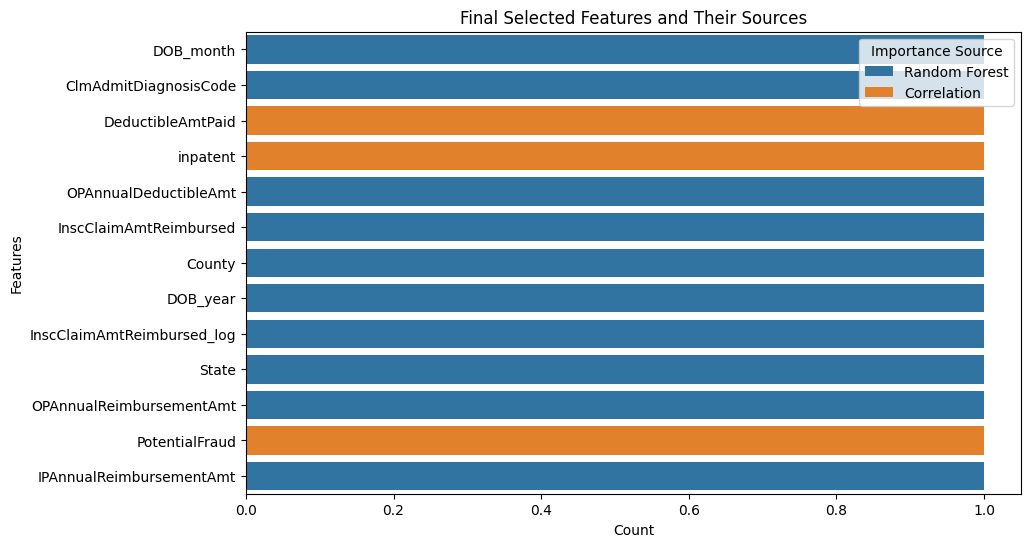

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame to show feature importance from both methods
feature_importance_df = pd.DataFrame({
    "Features": final_important_features,
    "Importance Source": ["Correlation" if feature in important_features_corr else "Random Forest" for feature in final_important_features]
})

# Plot a bar chart to visualize feature importance selection
plt.figure(figsize=(10, 6))
sns.countplot(data=feature_importance_df, y="Features", hue="Importance Source", order=feature_importance_df["Features"].value_counts().index)
plt.title("Final Selected Features and Their Sources")
plt.xlabel("Count")
plt.ylabel("Features")
plt.legend(title="Importance Source")
plt.show()


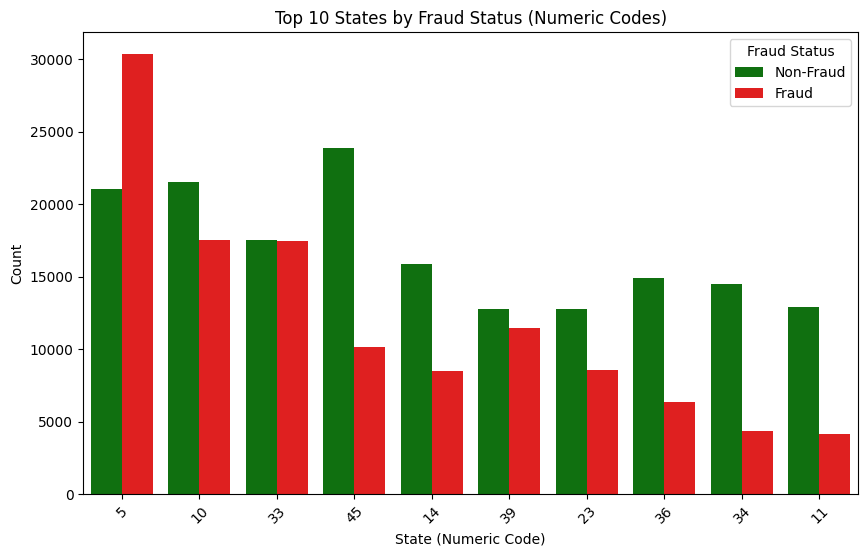

In [280]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for Top 10 States (numeric)
top_states = data_join['State'].value_counts().nlargest(10).index
data_join_filtered = data_join[data_join['State'].isin(top_states)]

# Countplot for State with custom colors
plt.figure(figsize=(10, 6))
sns.countplot(
    data=data_join_filtered,
    x='State',
    hue='PotentialFraud',
    order=top_states,
    palette={0: "green", 1: "red"}  # 0: Non-Fraud (Green), 1: Fraud (Red)
)
plt.title("Top 10 States by Fraud Status (Numeric Codes)")
plt.xlabel("State (Numeric Code)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Fraud Status", labels=["Non-Fraud", "Fraud"])
plt.show()


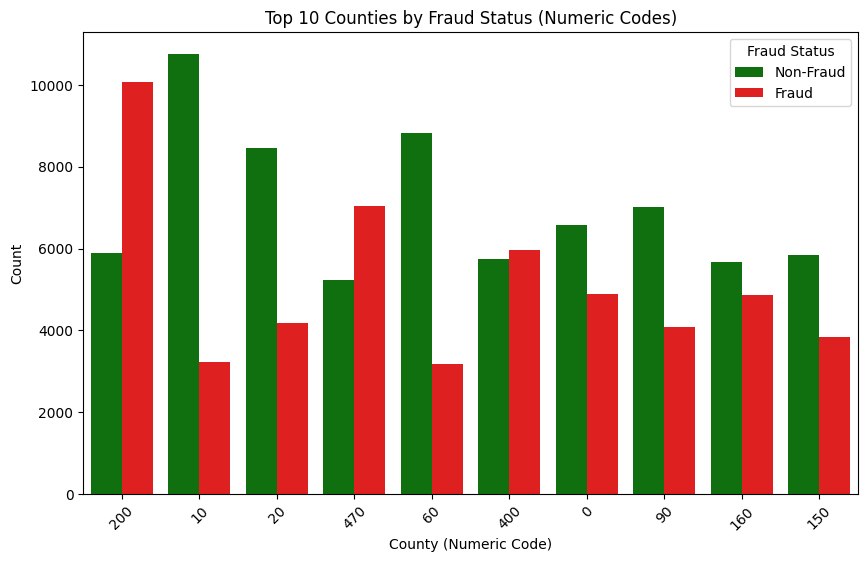

In [281]:
# Filter for Top 10 Counties (numeric)
top_counties = data_join['County'].value_counts().nlargest(10).index
data_join_filtered_county = data_join[data_join['County'].isin(top_counties)]

# Countplot for County with custom colors
plt.figure(figsize=(10, 6))
sns.countplot(
    data=data_join_filtered_county,
    x='County',
    hue='PotentialFraud',
    order=top_counties,
    palette={0: "green", 1: "red"}  # 0: Non-Fraud (Green), 1: Fraud (Red)
)
plt.title("Top 10 Counties by Fraud Status (Numeric Codes)")
plt.xlabel("County (Numeric Code)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Fraud Status", labels=["Non-Fraud", "Fraud"])
plt.show()


### Graph Visualization

Constructed a graph representation using the first dataset to analyze connections and relationships between nodes (e.g., Beneficiary IDs or Providers). A subgraph with a limited number of nodes was visualized using a spring layout, ensuring clarity in node placement and edge connections. This helps in understanding the structural patterns in the data.


Graph has 462 nodes and 415 edges.


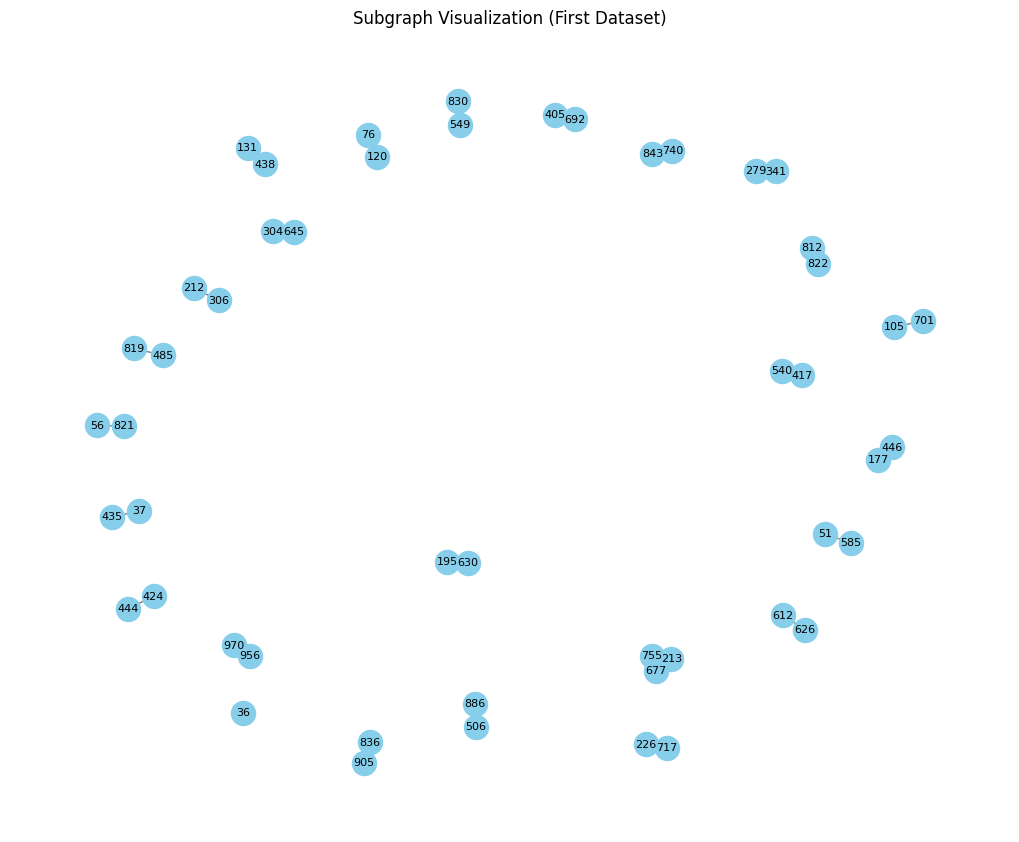

In [282]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a NetworkX graph from the first dataset
G = nx.Graph()
G.add_edges_from(zip(dataset[0][1][0], dataset[0][1][1]))

# Display basic graph information
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Visualize the graph (small subgraph for readability)
num_nodes_to_display = 50  # Adjust this for a smaller/larger subgraph
subgraph = G.subgraph(list(G.nodes)[:num_nodes_to_display])

# Use a spring layout for better node placement
pos = nx.spring_layout(subgraph, seed=42)

# Draw the graph with node labels and edges
plt.figure(figsize=(10, 8))
nx.draw(
    subgraph, pos,
    with_labels=True,
    node_size=300,
    node_color="skyblue",
    font_size=8,
    edge_color="gray"
)
plt.title("Subgraph Visualization (First Dataset)")
plt.show()


### Fraud vs Non-Fraud Node Visualization

Visualized a subgraph with nodes color-coded based on their fraud status: red for fraudulent and green for non-fraudulent nodes. The graph layout was enhanced with a spring algorithm for better node distribution. A legend was included to distinguish between fraudulent and non-fraudulent nodes, aiding in identifying fraud-related patterns within the dataset.


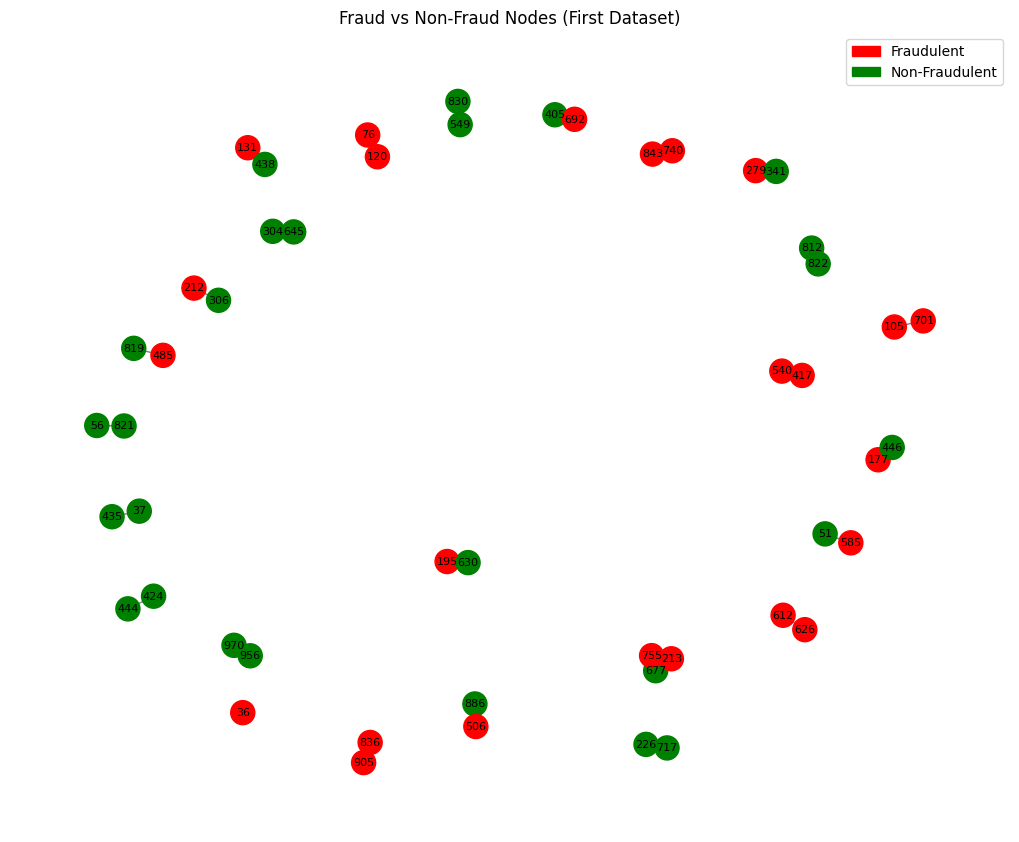

In [283]:
import matplotlib.patches as mpatches

# Generate node colors
node_colors = [
    "red" if data_join.loc[node, "PotentialFraud"] == 1 else "green"
    for node in subgraph.nodes
]

# Create legend
fraud_patch = mpatches.Patch(color="red", label="Fraudulent")
non_fraud_patch = mpatches.Patch(color="green", label="Non-Fraudulent")

plt.figure(figsize=(10, 8))
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    node_size=300,
    node_color=node_colors,
    font_size=8,
    edge_color="gray"
)
plt.legend(handles=[fraud_patch, non_fraud_patch], loc="upper right", fontsize=10)
plt.title("Fraud vs Non-Fraud Nodes (First Dataset)")
plt.show()


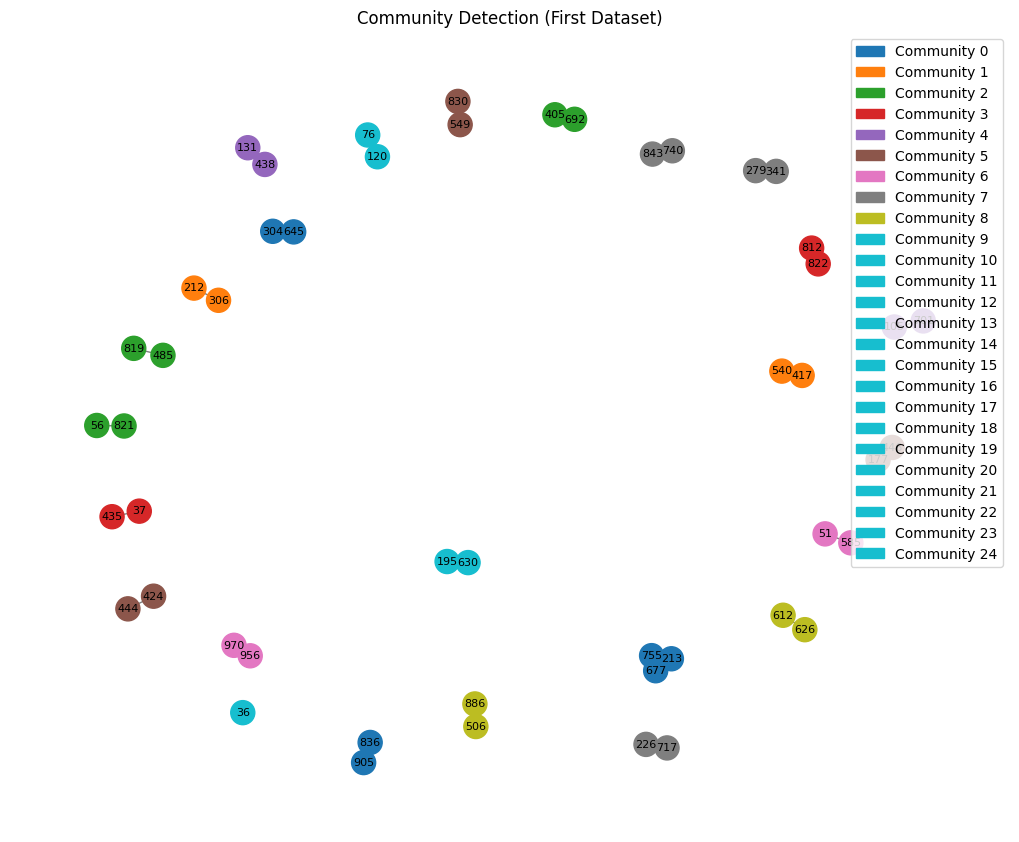

In [284]:
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.patches as mpatches

# Generate communities
communities = list(greedy_modularity_communities(subgraph))
community_colors = {node: idx for idx, community in enumerate(communities) for node in community}
node_colors = [community_colors[node] for node in subgraph.nodes]

# Create a color map legend
unique_colors = list(set(node_colors))
legend_patches = [
    mpatches.Patch(color=plt.cm.tab10(color), label=f"Community {color}")
    for color in unique_colors
]

plt.figure(figsize=(10, 8))
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    node_size=300,
    node_color=node_colors,
    cmap=plt.cm.tab10,
    font_size=8,
    edge_color="gray"
)
plt.legend(handles=legend_patches, loc="upper right", fontsize=10)
plt.title("Community Detection (First Dataset)")
plt.show()
